In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import hmp
from mne.io import read_info
import warnings
import pandas as pd
from utils import latency_model_fit, r_squared
import bambi as bmb
import arviz as az
from scipy.stats import gamma
from mne.viz import plot_topomap
from scipy.signal import windows
from mne.stats import permutation_cluster_1samp_test
from matplotlib.lines import Line2D 

eeg_data_path = os.path.join('data','preprocessed/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if '.fif' in x]#Extracting subject name based on the file name
subj_files = [eeg_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

# Load sensor position for an example participants (assumes all have the same channel position)
info = read_info(subj_files[0], verbose=True)

sfreq = info['sfreq'] #at what sampling rate we want the data, replace with 100Hz for speed/RAM
tstep = (1000/sfreq) #Time step for plotting

# REad epoch data but ignore RT
epoch_data = hmp.io.read_mne_data(subj_files, epoched=True, sfreq=sfreq, 
                                     verbose=False,
                                     subj_idx=subj_names,
                                     ignore_rt=True)
# REcover estiation
model = hmp.io.load_model('estimation_files/model.pkl')
estimates = hmp.io.load_model('estimation_files/estimates.pkl')

Processing participant data/preprocessed/6_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/6_epo.fif
Processing participant data/preprocessed/19_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/19_epo.fif
Processing participant data/preprocessed/20_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/20_epo.fif
Processing participant data/preprocessed/10_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/10_epo.fif
Processing participant data/preprocessed/0_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/0_epo.fif
Processing participant data/preprocessed/11_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/11_epo.fif
Processing participant data/preprocessed/23_epo.fif's epoched eeg
1116 trials were retained for participant data/preprocessed/23_epo.fif
Processing participant data/preprocessed/14_e

In [2]:
times_sp = hmp.utils.event_times(estimates, mean=False, add_rt=True, add_stim=True)

tstep = 1000/sfreq 

data = epoch_data.stack({'trial':['participant','epoch']}).data.dropna('trial', how="all")
data['stimulus'] = data.stimulus.astype(int)
data['rt'] = times_sp[:,-1]*tstep
data['Stimulus'] = times_sp[:,0]*tstep
data['P100'] = times_sp[:,1]*tstep
data['N200'] = times_sp[:,2]*tstep
data['CPP'] = times_sp[:,3]*tstep
weights =  hmp.utils.event_channels(epoch_data, estimates, mean=True)

name_sat = {'speed':'Speed','accuracy':'Accuracy'}
ax_sat = {"speed":0, "accuracy":1}
channels = info['ch_names'][:32]
decision_event = 2

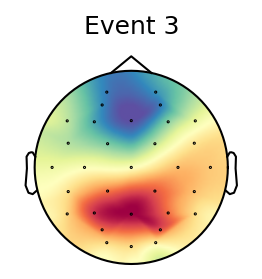

In [3]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(2,2))
plot_topomap(weights.sel(event=decision_event).values[:,0], info, sensors=True, cmap='Spectral_r', res=100, show=False, axes=ax, contours=False)
ax.set_title(f'Event {decision_event+1}')
fig.savefig('plots/topo.png', transparent=True, dpi=300)


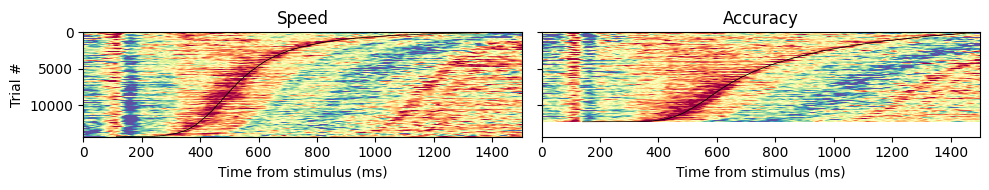

In [4]:
def gauss_window(sorted_mvp):
    gauss_k = windows.gaussian(50, 20)

    #convolve
    x = np.zeros(sorted_mvp.shape)*np.nan
    for t in range(sorted_mvp.shape[1]):
        x[:,t] = np.convolve(sorted_mvp[:,t], gauss_k, mode="same")
    # Zscore
    x = (x-np.tile(np.nanmean(x, axis=1), (x.shape[1], 1)).T)\
            /np.tile(np.nanstd(x, axis=1), (x.shape[1], 1)).T
    return x

n_samples = 1.5*sfreq
fig, ax = plt.subplots(1, 2,figsize=(10, 2), sharey=True)
for SAT in ['accuracy','speed']:
    data_left_sp = data.where((data.condition == SAT), drop=True).dropna('trial', how="all")

    #Used for RTs
    centered_rt = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                    event=0, n_samples=n_samples, cut_before_event=0, cut_after_event=4,
                    baseline=0)
    #Actual mvp values
    centered_surface = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                    event=0, n_samples=n_samples, cut_before_event=0, cut_after_event=0,
                    baseline=0)
    rts_surface = np.isnan(centered_rt.data.sel(channel='Cz')).sum('sample').values
    rts_surface_sort = np.argsort(rts_surface)
    rts_surface_sort = rts_surface_sort[int(np.sum(rts_surface == 0)):-int(np.sum(rts_surface >= n_samples))]
    mvp_tc = np.dot(centered_surface.data.transpose('trial', 'sample','channel').data, weights.sel(event=decision_event).values[:,0])[rts_surface_sort]
    filtered_zscored = gauss_window(mvp_tc)
    ax[ax_sat[SAT]].imshow(filtered_zscored, vmin=-2, vmax=2, cmap='Spectral_r', 
        interpolation='none',  extent=[0,n_samples*tstep,mvp_tc.shape[0],0], aspect='auto')
    ax[ax_sat[SAT]].plot((n_samples-rts_surface[rts_surface_sort][::-1])*tstep, np.arange(len(rts_surface_sort))[::-1], color='k', lw=.5)
    if ax_sat[SAT] == 0:
        ax[ax_sat[SAT]].set_ylabel('Trial #')
    ax[ax_sat[SAT]].set_xlim(0, 1500)
    ax[ax_sat[SAT]].set_title(SAT.capitalize())
    ax[ax_sat[SAT]].set_xlabel('Time from stimulus (ms)')
fig.tight_layout()
plt.savefig('plots/single-trial_CPP.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

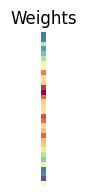

In [5]:
fig, ax = plt.subplots(figsize=(1,2))
plt.imshow(np.array([weights.sel(event=decision_event)[:,0]]).T, cmap='Spectral_r')
plt.axis("off")
plt.title('Weights')
plt.savefig("plots/weights.png", transparent=True, dpi=300)

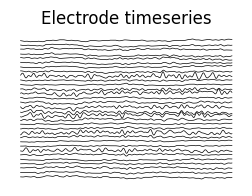

In [6]:
fig, ax = plt.subplots(figsize=(3,2))
xlim = int(1*sfreq)
plt.plot(epoch_data.isel(participant = 0, epoch=0, sample=range(xlim)).data.values.T + np.tile(np.arange(len(channels))*3e-5, (xlim,1)), color='k', lw=.5)
plt.axis("off")
plt.title('Electrode timeseries')
plt.savefig("plots/elecs.png", transparent=True, dpi=300)

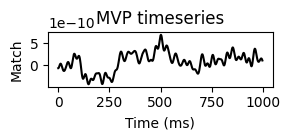

In [7]:
fig, ax = plt.subplots(figsize=(3,1.5))
xlim = int(1000/tstep)
plt.plot(np.arange(xlim)*tstep, epoch_data.isel(participant = 0, epoch = 0, sample=range(xlim)).data.values.T@weights.sel(event=decision_event).values, color='k')
plt.ylabel('Match')
plt.title('MVP timeseries')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.savefig("plots/timecourse.png", transparent=True, dpi=300)

In [8]:
contrasts = (np.linspace(0.034999999,0.9550001,11)*100)
color_cont_greys = {x: plt.cm.Greys(x/100) for x in contrasts}
color_cont_spd = {x: plt.cm.Reds(x/100) for x in contrasts}
color_cont_acc = {x: plt.cm.Blues(x/100) for x in contrasts}
color_sat = {'speed':color_cont_spd,'accuracy':color_cont_acc}

contrasts_bin = (np.linspace(0.034999999,0.9550001,3)*100)
color_cont_grey_bin = {x: plt.cm.Greys(x/100) for x in contrasts_bin}
color_cont_spd_bin = {x: plt.cm.Reds(x/100) for x in contrasts_bin}
color_cont_acc_bin = {x: plt.cm.Blues(x/100) for x in contrasts_bin}
color_sat_bin = {'speed':color_cont_spd_bin,'accuracy':color_cont_acc_bin}

Using a threshold of 2.059539
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 1 cluster


/tmp/ipykernel_1084465/313799622.py:62: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.063899
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 1 cluster


/tmp/ipykernel_1084465/313799622.py:62: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.059539
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 1 cluster


/tmp/ipykernel_1084465/313799622.py:62: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.063899
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 1 cluster


/tmp/ipykernel_1084465/313799622.py:62: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.059539
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 3 clusters


/tmp/ipykernel_1084465/313799622.py:62: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 2.063899
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 2 clusters


/tmp/ipykernel_1084465/313799622.py:62: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  test_stats = permutation_cluster_1samp_test(diff)


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

/tmp/ipykernel_1084465/313799622.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


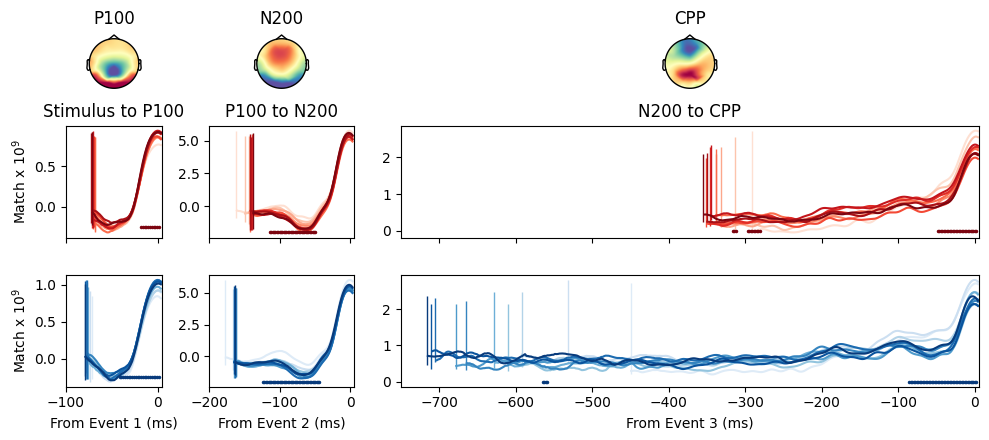

In [9]:
fig5 = plt.figure(constrained_layout=True, figsize=(10,4.5))

widths = [ 5, 7.5, 30]
heights = [ .5, 1, 1]
spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)

baseline = np.array([-.1, -.2, -.75])*sfreq
n_samples = np.array([.005,.005,.005])*sfreq
sig_ylim = [-0.25, -2, 0]

intervals = [['Stimulus','P100'], ['P100','N200'], ['N200','CPP']]

for event in np.arange(3):
    ax = fig5.add_subplot(spec5[0, event])
    plot_topomap(weights.sel(event=event).values[:,0], 
             info, sensors=False, cmap='Spectral_r', res=100, show=False, axes=ax, contours=False)
    ax.set_title(intervals[event][1])
    for c, SAT in enumerate(["speed","accuracy"]):
        ax = fig5.add_subplot(spec5[c+1, event])
        for j, cont in enumerate(list(zip(contrasts, np.roll(contrasts, -1)))[:-1]):
            data_left_sp = data.where((data.stimulus > cont[0]) & (data.stimulus <= cont[1])& (data.condition == SAT), drop=True)
            if SAT == 'accuracy':
                ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True)
                ax.set_xlabel(f'From Event {event+1} (ms)')
            else:
                ax.tick_params(bottom=True, labelbottom=False, left=True, labelleft=True)
                ax.set_title(f'{intervals[event][0]} to {intervals[event][1]}')
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                event=event+1, n_samples=n_samples[event], baseline=baseline[event])
            mean_time = (data_left_sp[intervals[event][0]].mean()-data_left_sp[intervals[event][1]].mean())/tstep
            centered = centered.sel(sample=slice(mean_time, n_samples[event]))

            timecourse = centered.data.unstack().mean(['epoch']).mean('participant').data.T@weights.sel(event=event).values
            timecourse *= 1e10
            ax.plot(centered.sample*tstep, timecourse,
                                 color=color_sat[SAT][cont[1]])
            ax.vlines(mean_time*tstep, 
                      np.nanmin(timecourse), np.nanmax(timecourse), 
                      color=color_sat[SAT][cont[1]], alpha=1, lw=1)

            ax.set_xlim(baseline[event]*tstep, n_samples[event]*tstep)
            if event == 0:
                ax.set_ylabel(r'Match x $10^{9}$')
        
        #Statistical testing on binarized contrast values
        activ = np.zeros((2, len(epoch_data.participant), int((abs(baseline[event])+n_samples[event]))))*np.nan
        for j, cont in enumerate(list(zip(contrasts_bin, np.roll(contrasts_bin, -1)))[:-1]):
            data_left_sp = data.where((data.stimulus > cont[0]) & (data.stimulus <= cont[1])& (data.condition == SAT), drop=True).dropna('trial', how="all")
            centered = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                event=event+1, n_samples=n_samples[event], baseline=baseline[event])
            sample_range = centered.sample.values
            centered = centered.data.unstack()
            mean_time = int(np.rint((data_left_sp[intervals[event][0]].mean()-data_left_sp[intervals[event][1]].mean())/tstep))
            centered = centered.sel(sample=slice(mean_time, n_samples[event]))
            participant_erp = np.zeros((len(centered.participant), len(centered.sample)))*np.nan
            for i, participant in enumerate(centered.participant):
                participant_erp[i] = centered.sel(participant = participant).mean(['epoch']).data.T@weights.sel(event=event).values[:,0]
            activ[j, :, -len(centered.sample):] = participant_erp
        diff = activ[0] - activ[1]
        diff = diff[np.isfinite(diff[:,-1]),:]
        test_stats = permutation_cluster_1samp_test(diff)
        if isinstance(test_stats[1], list):
            sig = np.concatenate([arr[0] for arr in test_stats[1]])
        else: sig =  test_stats[1]
        if len(sig ) > 0:
            ax.plot((sample_range*tstep)[sig], np.repeat(sig_ylim[event], len(sig)), '.', color=color_sat_bin[SAT][cont[1]], markersize=3)
            
plt.tight_layout()
plt.savefig('plots/ERPs_partition.png',dpi=300,transparent=True,bbox_inches='tight')

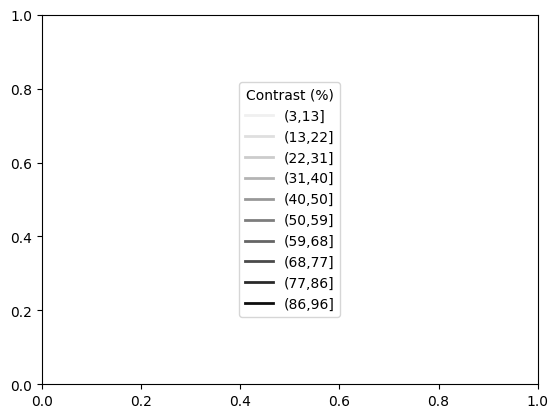

In [10]:
legend_elements = []
for j, cont in enumerate(list(zip(contrasts, np.roll(contrasts, -1)))[:-1]):
    legend_elements.append(Line2D([0], [0], color=color_cont_greys[cont[1]], lw=2, label="(%s,%s]"%(int(np.round(cont[0])),int(np.round(cont[1])))))
# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', title='Contrast (%)')
plt.savefig('plots/ERPs_legend_%s.png'%sfreq,dpi=300,transparent=True,bbox_inches='tight')
plt.show()

# Generating banner image

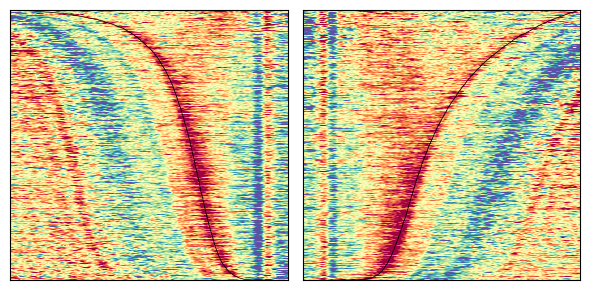

In [11]:
def gauss_window(sorted_mvp):
    gauss_k = windows.gaussian(50, 20)

    #convolve
    x = np.zeros(sorted_mvp.shape)*np.nan
    for t in range(sorted_mvp.shape[1]):
        x[:,t] = np.convolve(sorted_mvp[:,t], gauss_k, mode="same")
    # Zscore
    x = (x-np.tile(np.nanmean(x, axis=1), (x.shape[1], 1)).T)\
            /np.tile(np.nanstd(x, axis=1), (x.shape[1], 1)).T
    return x

n_samples = 1.5*sfreq
fig, ax = plt.subplots(1,2,figsize=(6, 3), sharey=False)
for SAT in ['accuracy','speed']:
    data_left_sp = data.where((data.condition == SAT), drop=True).dropna('trial', how="all")

    #Used for RTs
    centered_rt = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                    event=0, n_samples=n_samples, cut_before_event=0, cut_after_event=4,
                    baseline=0)
    #Actual mvp values
    centered_surface = hmp.utils.centered_activity(data_left_sp, times_sp, channels,
                    event=0, n_samples=n_samples, cut_before_event=0, cut_after_event=0,
                    baseline=0)
    rts_surface = np.isnan(centered_rt.data.sel(channel='Cz')).sum('sample').values
    rts_surface_sort = np.argsort(rts_surface)
    rts_surface_sort = rts_surface_sort[int(np.sum(rts_surface == 0)):-int(np.sum(rts_surface >= n_samples))]
    mvp_tc = np.dot(centered_surface.data.transpose('trial', 'sample','channel').data, weights.sel(event=decision_event).values[:,0])[rts_surface_sort]
    filtered_zscored = gauss_window(mvp_tc)
    ax[ax_sat[SAT]].imshow(filtered_zscored, vmin=-2, vmax=2, cmap='Spectral_r', 
        interpolation='none',  extent=[0,n_samples*tstep,mvp_tc.shape[0],0], aspect='auto')
    ax[ax_sat[SAT]].plot((n_samples-rts_surface[rts_surface_sort][::-1])*tstep, np.arange(len(rts_surface_sort))[::-1], color='k', lw=.5)
    # ax[ax_sat[SAT]].set_xlabel('Time from stimulus (ms)')
    ax[ax_sat[SAT]].set_xlim(0, 1500)
    if ax_sat[SAT] == 0:
        ax[ax_sat[SAT]].xaxis.set_inverted(True)
    ax[ax_sat[SAT]].tick_params(bottom=False, labelbottom=False, 
                                left=False, labelleft=False)
fig.tight_layout()
plt.savefig('plots/bump_banner.jpg',dpi=300,transparent=True,bbox_inches='tight')
plt.show()